In [43]:
import os
import numpy as np
import pandas as pd
from torch import torch, nn, optim
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader



In [2]:
def read_data_from_csv(path):
    """Load datasets from CSV files.
    Args:
        path (str): Path to the CSV file.
    Returns:
        X (np.ndarray): Features of samples.
        y (np.ndarray): Labels of samples, only provided in the public datasets.
    """
    assert os.path.exists(path), f'File not found: {path}!'
    assert os.path.splitext(path)[
        -1] == '.csv', f'Unsupported file type {os.path.splitext(path)[-1]}!'

    data = pd.read_csv(path)
    column_list = data.columns.values.tolist()

    if 'Label' in column_list:
        # for the public dataset, label column is provided.
        column_list.remove('Label')
        X = data[column_list].values
        y = data['Label'].astype('int').values
        return X, y
    else:
        # for the private dataset, label column is not provided.
        X = data[column_list].values
        return X

def renameCols(df: pd.DataFrame):
    df_new = df.rename(
        columns={
            0: 'Credit', 
            1: 'Gender',
            2: 'Edu',
            3: 'Marital',
            4: 'Age',
            5: 'RePay_Sep',
            6: 'RePay_Aug',
            7: 'RePay_Jul',
            8: 'RePay_Jun',
            9: 'RePay_May',
            10: 'RePay_Apr',
            11: 'Bill_Sep',
            12: 'Bill_Aug',
            13: 'Bill_Jul',
            14: 'Bill_Jun',
            15: 'Bill_May',
            16: 'Bill_Apr',
            17: 'Paid_Sep',
            18: 'Paid_Aug',
            19: 'Paid_Jul',
            20: 'Paid_Jun',
            21: 'Paid_May',
            22: 'Paid_Apr'
        }
    ) 
    return df_new

def handleCateg(df: pd.DataFrame):
    # binary label / category: 2
    # categories: 3, 4
    # rating categories: 6-11
    df_new = df
    # df['Class'] = df['Class'].map({'Individual':'Individual', 'Group':'Group'}).fillna('Other')
    df_isMale = df_new['Gender'].map({1: True, 2: False}).fillna(False)
    df_new['Edu'] = df_new['Edu'].map({1:'graduateSc', 2:'university', 3:'highSc'}).fillna('others')
    df_new['Marital'] = df_new['Marital'].map({1:'married', 2:'single'}).fillna('others')
    df_new['Gender'] = df_isMale

    return df_new

def oneHotEncoding(df: pd.DataFrame):
    df_ohe = pd.get_dummies(df)
    df_ohe = df_ohe[[
        'Credit', 'Gender', 
	    'Edu_graduateSc', 'Edu_highSc', 'Edu_university', 'Edu_others',
	    'Marital_married', 'Marital_single', 'Marital_others',
	    'Age',
        'RePay_Sep', 'RePay_Aug', 'RePay_Jul', 'RePay_Jun', 'RePay_May', 'RePay_Apr',
        'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
        'Paid_Sep', 'Paid_Aug', 'Paid_Jul', 'Paid_Jun', 'Paid_May', 'Paid_Apr'
    ]]

    return df_ohe

In [15]:
X_public, y_public = read_data_from_csv('assignment_6_public.csv')
print('Shape of X_public:', X_public.shape)  # n_sample, m_feature (20000, 23)
print('Shape of y_public:', y_public.shape)  # n_sample (20000,)

X_private = read_data_from_csv('assignment_6_private.csv')
print('Shape of X_private:', X_private.shape)  # k_sample, m_feature (5000, 23)

# rename columns, categorize and one-hot encoding
preprocess_x = oneHotEncoding(handleCateg(renameCols(pd.DataFrame(X_public))))


Shape of X_public: (20000, 23)
Shape of y_public: (20000,)
Shape of X_private: (5000, 23)


In [4]:
preprocess_x

,Credit,Gender,Edu_graduateSc,Edu_highSc,Edu_university,Edu_others,Marital_married,Marital_single,Marital_others,Age,...,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Paid_Sep,Paid_Aug,Paid_Jul,Paid_Jun,Paid_May,Paid_Apr
0,20000,True,False,False,True,False,True,False,False,24,...,17473,16900,17690,18255,1000,0,0,1376,1000,649
1,130000,False,False,False,True,False,False,True,False,24,...,41,1062,-201,-201,0,41,1021,0,0,0
2,120000,True,True,False,False,False,False,True,False,27,...,38083,36728,36952,35475,2415,1816,1381,1264,1228,1217
3,300000,True,False,True,False,False,False,True,False,51,...,6246,3872,11875,5290,19854,6279,3883,11883,5305,9998
4,130000,False,False,True,False,False,True,False,False,43,...,129385,96775,98071,97743,6739,5540,4403,3814,3562,4021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,170000,False,False,False,True,False,False,True,False,35,...,118111,92592,96114,99628,5000,5000,10000,5000,5000,5000
19996,70000,False,True,False,False,False,False,True,False,31,...,2400,2400,2400,2400,0,0,0,0,0,0
19997,280000,False,True,False,False,False,False,True,False,52,...,930,0,0,0,0,930,0,0,0,0
19998,20000,True,True,False,False,False,False,True,False,23,...,19753,19160,19661,19816,2300,0,0,788,558,198


In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
print("GPU:", torch.cuda.get_device_name())

Using cuda device
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [25]:
torch.manual_seed(0)

df_public = pd.concat([oneHotEncoding(handleCateg(renameCols(pd.DataFrame(X_public)))), pd.DataFrame(y_public)], axis=1).rename(columns={0: 'Target'})

# train_data, test_data = df_public.sample(frac=0.8, random_state=0)
train_df, test_df = train_test_split(df_public, test_size=0.12, random_state=0)

In [26]:
print(train_df.shape)
print(test_df.shape)

(17600, 29)
(2400, 29)


In [27]:
train_df

,Credit,Gender,Edu_graduateSc,Edu_highSc,Edu_university,Edu_others,Marital_married,Marital_single,Marital_others,Age,...,Bill_Jun,Bill_May,Bill_Apr,Paid_Sep,Paid_Aug,Paid_Jul,Paid_Jun,Paid_May,Paid_Apr,Target
7863,260000,False,False,True,False,False,True,False,False,31,...,0,0,0,0,0,0,0,0,7287,0
11720,30000,False,True,False,False,False,False,True,False,28,...,5931,7665,9535,1230,1241,1000,2000,2000,0,0
7847,100000,False,True,False,False,False,True,False,False,45,...,0,0,0,5220,0,0,0,0,0,1
12377,220000,False,False,False,True,False,False,True,False,30,...,11642,23030,22449,892,7681,20000,20000,0,0,0
12022,60000,False,True,False,False,False,False,True,False,27,...,16553,14259,14134,1283,1584,1217,496,662,489,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,170000,False,False,False,True,False,True,False,False,42,...,2437,2881,2659,2000,1000,2437,3103,2659,2659,0
19648,110000,False,False,False,True,False,False,True,False,36,...,34519,29541,42400,5000,2000,2000,2000,16468,3000,0
9845,50000,True,False,False,True,False,True,False,False,43,...,48934,29116,28999,1800,2200,1400,582,580,30000,0
10799,30000,True,False,True,False,False,False,True,False,51,...,28957,29408,29840,1800,1300,2400,1000,1000,0,0


In [41]:
train_data  = pd.DataFrame(train_df).drop(columns='Target')
train_labels = pd.DataFrame(train_df)['Target']

test_data  = pd.DataFrame(test_df).drop(columns='Target')
test_labels = pd.DataFrame(test_df)['Target']

In [40]:
type(train_data.to_numpy())

numpy.ndarray

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Convert the numpy arrays into PyTorch tensors
X_train = torch.Tensor(train_data.to_numpy().astype(float)).to(device)
Y_train = torch.LongTensor(train_labels.to_numpy().astype(float)).to(device)
X_test = torch.Tensor(test_data.to_numpy().astype(float)).to(device)
Y_test = torch.LongTensor(test_labels.to_numpy().astype(float)).to(device)


# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [49]:
device

device(type='cuda')

Epoch: 100, Loss: 21.8952, Accuracy: 0.6258
Epoch: 200, Loss: 25.7647, Accuracy: 0.7650
Epoch: 300, Loss: 21.0312, Accuracy: 0.7733
Epoch: 400, Loss: 6.7806, Accuracy: 0.7692
Epoch: 500, Loss: 1.4423, Accuracy: 0.7150
Epoch: 600, Loss: 1.6199, Accuracy: 0.7621
Epoch: 700, Loss: 2.9732, Accuracy: 0.7708
Epoch: 800, Loss: 0.8824, Accuracy: 0.6371
Epoch: 900, Loss: 0.6339, Accuracy: 0.7692
Epoch: 1000, Loss: 0.7141, Accuracy: 0.6875


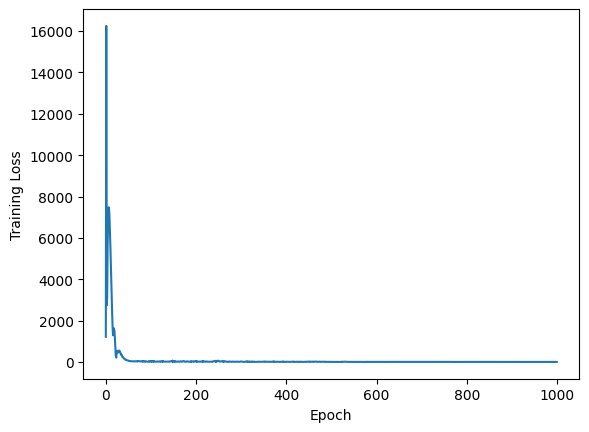

In [68]:

def fit(model, criterion, optimizer, X_train, Y_train):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    return loss.item()

def predict(model, X):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
    return predicted

# Initialize the model and define loss and optimizer
model = Net().to(device)  # Initialize the model and move it to GPU if available
criterion = nn.CrossEntropyLoss()  # Define the loss function (Cross Entropy Loss)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Define the optimizer (Adam)

# Training loop
num_epochs = 1000
batch_size = 32
train_losses = []

for epoch in range(num_epochs):
    loss = fit(model, criterion, optimizer, X_train, Y_train)
    train_losses.append(loss)

    # Validate accuracy every 100 epochs
    if (epoch + 1) % 100 == 0:
        
        predicted = predict(model, X_test)

        correct = (predicted == Y_test).sum().item()
        total = Y_test.size(0)
        accuracy = correct / total

        print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


# Plotting the training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Best Epoch: 300, Loss: 21.0312, Accuracy: 0.7733

In [69]:
# Initialize the model and define loss and optimizer
model = Net().to(device)  # Initialize the model and move it to GPU if available
criterion = nn.CrossEntropyLoss()  # Define the loss function (Cross Entropy Loss)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Define the optimizer (Adam)


X_private = read_data_from_csv('assignment_6_private.csv')
# rename columns, categorize and one-hot encoding
preprocess_private = oneHotEncoding(handleCateg(renameCols(pd.DataFrame(X_private))))
X_private_tenser = torch.Tensor(preprocess_private.to_numpy().astype(float)).to(device)

# Training loop
num_epochs = 300
batch_size = 32
train_losses = []

preds = []

for epoch in range(num_epochs):
    loss = fit(model, criterion, optimizer, X_train, Y_train)
    train_losses.append(loss)

    # Validate accuracy every 100 epochs
    if (epoch + 1) % 100 == 0:
        
        predicted = predict(model, X_test)

        correct = (predicted == Y_test).sum().item()
        total = Y_test.size(0)
        accuracy = correct / total

        print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    
    if (epoch + 1) == 300:
        preds = predict(model, X_private_tenser)

Epoch: 100, Loss: 43.5349, Accuracy: 0.5467
Epoch: 200, Loss: 45.5298, Accuracy: 0.6771
Epoch: 300, Loss: 10.4769, Accuracy: 0.7158


In [76]:
# from collections import Counter

# counts = Counter(preds.cpu())
length = len(preds)
numOne = torch.count_nonzero(preds)

# Print the counts
print("Count of 0:", length - numOne)
print("Count of 1:", numOne)

Count of 0: tensor(4453, device='cuda:0')
Count of 1: tensor(547, device='cuda:0')


In [71]:
submission = pd.DataFrame({'Label': preds.cpu()})
submission.to_csv('assignment_6.csv', index=True, index_label='Id')